# Example of how to use Deep Learning for text classification

Click [Text Classification Example](https://colab.research.google.com/github/magic-lantern/coprh-nlp-2021/blob/main/text_classification_colab.ipynb) to open this notebook in Google Colab - no local setup required, results saved to your Google Drive.

In Google Colab, make sure you change the Runtime to a GPU instance - that will result vastly improved runtimes for deep learning steps. On CPU based hardware some steps take 40 minutes versus 1 minute per training epoch on systems with a GPU. Steps to update runtime:

    Runtime > Change runtime type > Select 'GPU' in Hardware accelerator box

Click 'Save' to switch from Default runtime to GPU accelerated runtime.

Some useful links:

* https://muellerzr.github.io/fastblog/2020/08/21/intermediate.html#A-Text-Example

In [1]:
# this cell makes sure Google Colab version has latest software dependencies
!pip install -Uqq fastbook fastai

     |████████████████████████████████| 727kB 18.2MB/s 
     |████████████████████████████████| 204kB 54.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 1.2MB 52.5MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 


In [2]:
import fastbook
import gc

In [3]:
# this cell will setup a path that allows you to load and save files to your google drive
# you will be prompted to log in with a Google enabled account.
fastbook.setup_book()

Mounted at /content/gdrive


In [4]:
from fastai.text.all import *

In [5]:
Path.cwd()

Path('/content')

In [6]:
data_path = fastbook.gdrive / Path('data')
data_file = data_path / 'mtsamples.csv'
sequence_length = 512

In [7]:
data_file

Path('/content/gdrive/My Drive/data/mtsamples.csv')

In [8]:
if data_file.is_file():
    print('Already downloaded')
else:
    print('downloading data file')
    download_data(
        url='https://github.com/socd06/medical-nlp/raw/master/data/mtsamples.csv',
        fname = data_file
    )

Already downloaded


In [9]:
mtsamples = pd.read_csv(str(data_path) + '/mtsamples.csv')
# remove leading/trailing spaces from text fields
mtsamples = mtsamples.applymap(lambda x: x.strip() if isinstance(x, str) else x)
mtsamples.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. She has used Allegra also. She used that last summer and she began using it again two weeks ago. It does not appear to be working very well. She has used over-the-counter sprays but no prescription nasal sprays. She does have asthma but doest not require daily medication for this and does not think it...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two blocks or five flights of stairs. Difficulty with snoring. He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling. He has gastroesophageal reflux disease.,PAST SURGICAL HISTORY:, Includes reconstructive surgery on his right hand 13 years ago. ,SOCIAL HISTORY:, He is currently single. He has about te...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at his lowest 260. He is pursuing surgical attempts of weight loss to feel good, get healthy, and begin to exercise again. He wants to be able to exercise and play volleyball. Physically, he is sluggish. He gets tired quickly. He does not go out often. When he loses weight he always regains it and he gains back more than he lost. His biggest...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericardial effusion.,6. Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7. PA systolic pressure is 36 mmHg.,DOPPLER: , ,1. Mild mitral and tricuspid regurgitation.,2. Trace aortic and pulmonary regurgitation.","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation, systolic function, tricuspid, tricuspid valve, normal lv"
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,"1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consiste

A note on data cleanup. In the best case, a machine learning model can only be as good as the data provided. If data is of poor quality or inconsistent, it will be difficult to get good accuracy with your model.

Let's review the really short transcription notes.

In [10]:
word_len = mtsamples.transcription.str.split(' ').str.len()

In [11]:
mtsamples['num_words'] =  mtsamples.transcription.str.split(' ').str.len()

In [12]:
word_len.median()

425.0

In [13]:
word_len.min()

1.0

In [14]:
print(f"There are {len(mtsamples[mtsamples['num_words'] < 5])} records with short notes.")
mtsamples[mtsamples['num_words'] < 5].head()

There are 16 records with short notes.


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,num_words
24,24,Blood in urine - Transitional cell cancer of the bladder.,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,",NaN,2.0
872,872,EGD with dilation for dysphagia.,Surgery,EGD with Dilation,"INDICATION: ,","surgery, egd, hurricaine spray, olympus endoscope, savary wire, cricopharyngeus, decubitus, dilator, duodenum, dysphagia, esophagus, hiatal hernia, peptic, pylorus, stomach, tortuosity, egd with dilation, tortuous, scope, hiatal, hernia,",3.0
1379,1379,Sample progress note - Gen Med.,SOAP / Chart / Progress Notes,Gen Med SOAP - 1,"SUBJECTIVE:,","soap / chart / progress notes, progress note, clear to auscultation, s1, s2, s3, s4, blood pressure, clubbing, cyanosis, general medicine, peripheral edema, rubs, tenderness, abdomen, pressure, soap, blood",1.0
1525,1525,Dobutrex stress test for abnormal EKG,Radiology,Stress Test Dobutrex,"INDICATIONS:,","radiology, dobutrex stress test, abnormal ekg, dobutrex, inferior abnormality, ischemic heart disease, ventricle, µg/kg/minute, stress test, stress,",1.0
1949,1949,Trigger Point Injection. The area over the myofascial spasm was prepped with alcohol utilizing sterile technique.,Pain Management,Trigger Point Injection,"OPERATION:,","pain management, myofascial spasm, trigger point injection, trigger, injection, spasm",1.0


In [15]:
# drop transcripts with fewer than 5 words - they are not good notes
mtsamples = mtsamples[mtsamples['num_words'] >= 5]

In [16]:
mtsamples.medical_specialty.value_counts()

Surgery                          1087
Consult - History and Phy.        515
Cardiovascular / Pulmonary        370
Orthopedic                        352
Radiology                         272
General Medicine                  258
Neurology                         223
Gastroenterology                  223
SOAP / Chart / Progress Notes     165
Obstetrics / Gynecology           155
Urology                           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    59
Psychiatry / Psychology            53
Office Notes                       48
Podiatry                           47
Dermatology                        29
Dentistry                          27
Cosmetic / Plastic Surgery         27
Letters     

All machine learning models require a few examples to be able to train from. In this dataset, we will combine those categories with 20 or less examples into an 'Other' category. Later those more rare categories can be dealt with separately.

In [17]:
mtsamples.groupby(['medical_specialty'])['transcription'].transform('count')

0         7
1        18
2        18
3       370
4       370
       ... 
4994      7
4995      7
4996      7
4997      7
4998      7
Name: transcription, Length: 4950, dtype: int64

In [18]:
mtsamples['counts'] = mtsamples.groupby(['medical_specialty'])['transcription'].transform('count')

In [19]:
mtsamples.loc[mtsamples['counts'] < 21, 'medical_specialty'] = 'Other'
mtsamples.medical_specialty.value_counts()

Surgery                          1087
Consult - History and Phy.        515
Cardiovascular / Pulmonary        370
Orthopedic                        352
Radiology                         272
General Medicine                  258
Neurology                         223
Gastroenterology                  223
SOAP / Chart / Progress Notes     165
Obstetrics / Gynecology           155
Urology                           155
Other                             144
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    59
Psychiatry / Psychology            53
Office Notes                       48
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry   

In [20]:
mtsamples = mtsamples[mtsamples.counts > 20]

In [21]:
mtsamples.medical_specialty.value_counts()

Surgery                          1087
Consult - History and Phy.        515
Cardiovascular / Pulmonary        370
Orthopedic                        352
Radiology                         272
General Medicine                  258
Neurology                         223
Gastroenterology                  223
SOAP / Chart / Progress Notes     165
Obstetrics / Gynecology           155
Urology                           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    59
Psychiatry / Psychology            53
Office Notes                       48
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

### Setup objects for Language Model Training

This is one way to load the data for training - it's more simple, but you have less control.

```python
TextDataLoaders.from_df(mtsamples,
                        valid_pct=0.2,
                        seed=42,
                        text_col='transcription',
                        label_col='medical_specialty',
                        seq_len=72)
```

In [22]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('transcription', is_lm=True),
    get_x=ColReader('text'),
    splitter=TrainTestSplitter(test_size=0.2,
                               random_state=42)
)

In [23]:
# This cell takes 1 - 2 minutes
# when using seq_len of 256, bs of 128 fits in GPU memory, bs 256 does not fit
# when using seq_len of 512, bs of 64 fits in GPU memory, bs 128 does not fit
dls_lm = dls_lm.dataloaders(mtsamples, bs=32, seq_len=sequence_length)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Train the language Model

This portion can be skipped if done previously

In [24]:
# if changes in the above were made (such as batch size), it may be beneficial to purge GPU memory
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [25]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxup chief xxup complaint ( 1 / 1 ) : , xxmaj this 62 year old female presents today for evaluation of angina . ,associated signs and symptoms : xxmaj associated signs and symptoms include chest pain , nausea , pain radiating to the arm and pain radiating to the jaw . xxunk : xxmaj the patient has had no previous treatments for this condition . ,duration : xxmaj condition has existed for 5 hours . ,quality : xxmaj quality of the pain is described by the patient as crushing . xxunk : xxmaj severity of condition is severe and unchanged . xxunk ( onset / frequency ) : xxmaj onset was sudden and with exercise . xxmaj patient has the following coronary risk factors : smoking 1 packs / day for 40 years and elevated cholesterol for 5 years . xxmaj patient 's elevated cholesterol is not being","xxup chief xxup complaint ( 1 / 1 ) : , xxmaj this 62 year old female presents today for evaluation of angina . ,associated signs and symptoms : xxmaj associated signs and symptoms include chest pain , nausea , pain radiating to the arm and pain radiating to the jaw . xxunk : xxmaj the patient has had no previous treatments for this condition . ,duration : xxmaj condition has existed for 5 hours . ,quality : xxmaj quality of the pain is described by the patient as crushing . xxunk : xxmaj severity of condition is severe and unchanged . xxunk ( onset / frequency ) : xxmaj onset was sudden and with exercise . xxmaj patient has the following coronary risk factors : smoking 1 packs / day for 40 years and elevated cholesterol for 5 years . xxmaj patient 's elevated cholesterol is not being treated"
1,"colonoscopy . xxmaj she is xxup g4 , xxup p3 , with no cesarean section . ,review xxup of xxup systems : , heent : xxmaj for headaches and sore throat . xxmaj musculoskeletal : xxmaj she is right handed with joint pain , stiffness , and decreased range of motion . xxmaj cardiac : xxmaj for heart murmur . xxup gi : xxmaj negative and noncontributory . xxmaj respiratory : xxmaj negative and noncontributory . xxmaj urinary : xxmaj negative and noncontributory . hem - onc : xxmaj negative and noncontributory . xxmaj vascular : xxmaj negative and noncontributory . xxmaj psychiatric : xxmaj negative and noncontributory . xxmaj genital : xxmaj negative and noncontributory . xxmaj she denies any bowel or bladder dysfunction or loss of sensation in her genital area . ,physical xxup examination : , xxmaj she is 5 feet 2 inches tall . xxmaj current",". xxmaj she is xxup g4 , xxup p3 , with no cesarean section . ,review xxup of xxup systems : , heent : xxmaj for headaches and sore throat . xxmaj musculoskeletal : xxmaj she is right handed with joint pain , stiffness , and decreased range of motion . xxmaj cardiac : xxmaj for heart murmur . xxup gi : xxmaj negative and noncontributory . xxmaj respiratory : xxmaj negative and noncontributory . xxmaj urinary : xxmaj negative and noncontributory . hem - onc : xxmaj negative and noncontributory . xxmaj vascular : xxmaj negative and noncontributory . xxmaj psychiatric : xxmaj negative and noncontributory . xxmaj genital : xxmaj negative and noncontributory . xxmaj she denies any bowel or bladder dysfunction or loss of sensation in her genital area . ,physical xxup examination : , xxmaj she is 5 feet 2 inches tall . xxmaj current weight"


In [26]:
lm_learn = language_model_learner(
    dls_lm,
    AWD_LSTM,
    model_dir=fastbook.gdrive / Path('data'),
    drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

In [27]:
# on macbook this cell takes 40 minues
# on GPU machine this cell takes about 1 minute
lm_learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.296636,2.982498,0.441904,19.737053,01:06


In [28]:
lm_learn.save('1stepoch')
# can load already saved trained model with
# learn.load('1stepoch')

Path('/content/gdrive/My Drive/data/1stepoch.pth')

In [29]:
# if changes in the above were made (such as batch size), it may be beneficial to purge GPU memory
# gc.collect()
# torch.cuda.empty_cache()
# gc.collect()
# torch.cuda.empty_cache()

In [30]:
lm_learn.unfreeze()
lm_learn.fit_one_cycle(30, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.882909,2.877978,0.454041,17.778282,01:14
1,2.791034,2.769066,0.467733,15.943729,01:13
2,2.664852,2.638365,0.484761,13.990305,01:13
3,2.508491,2.493161,0.504319,12.099459,01:13
4,2.334734,2.321356,0.529879,10.189485,01:14
5,2.121944,2.162823,0.554982,8.695648,01:13
6,1.912671,1.993129,0.585764,7.338458,01:14
7,1.706861,1.831785,0.617578,6.245022,01:13
8,1.510077,1.700571,0.643784,5.477075,01:14
9,1.361713,1.574467,0.670547,4.828168,01:13


In [31]:
lm_learn.save_encoder('finetuned')
# can load with
# lm_learn.load('finetuned')

## Now build a text classifier

Now that we have finetuned a language model based on our actual text let's build a classifier to identify the medical specialty of the transcription notes. As shown previously in this dataset, some specialties are more represented than others. Split data such that training and testing data sets are balanced based on specialty.

In [32]:
# this cell takes about 2 minutes to run
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('transcription', vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('medical_specialty'),
    splitter=TrainTestSplitter(test_size=0.2,
                               random_state=42,
                               stratify=mtsamples.medical_specialty)
).dataloaders(mtsamples, bs=128, seq_len=sequence_length)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [33]:
dls_clas.show_batch(max_n=2)

,text,category
0,"xxbos xxup date xxup of xxup injury : xxmaj october 4 , 2 xxrep 3 0 , date xxup of xxup examination : xxmaj september 5 , xxunk xxup physician : x xxup y , md , prior to the beginning of the examination , it is explained to the examinee that this examination is intended for evaluative purposes only , and that it is not intended to xxunk a general medical examination . xxmaj it is explained to the examinee that the traditional doctor - patient relationship does not apply to this examination , and that a written report will be provided to the agency requesting this examination . xxmaj it has also been emphasized to the examinee that he should not attempt any physical activity beyond his tolerance , in order to avoid injury . ,chief xxup complaint : , aching and mid back pain . ,history xxup",Letters
1,"xxbos xxup history xxup of xxup present xxup illness : , the patient is a 79-year - old right - handed man who reports that approximately one and a half years ago , he fell down while walking in the living room from the bedroom . xxmaj at that time , he reports both legs gave away on him and he fell . xxmaj he reported that he had some lightheadedness just before he fell and was slightly confused , but was aware of what was happening around him . xxmaj he was able to get up shortly after falling and according to the patient and his son , subsequently returned back to normal . ,he was then well until the 3rd of xxmaj july 2008 when his legs again gave way on him . xxmaj this was not preceded by lightheadedness . xxmaj he was rushed to the hospital",Consult - History and Phy.


In [34]:
learn = text_classifier_learner(
    dls_clas,
    AWD_LSTM,
    drop_mult=0.3,
    metrics=accuracy,
    model_dir=fastbook.gdrive / Path('data')).to_fp16()

In [35]:
# load the encoder used for the language model - must be the same to build off language model.
learn = learn.load_encoder('finetuned')

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.007585775572806597)

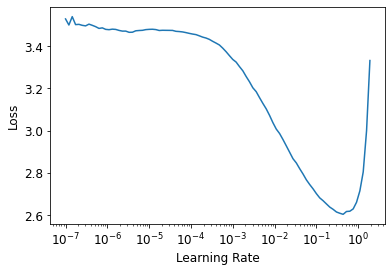

In [36]:
# attempt to find a decent learning rate for this dataset
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 3e-2)

In [ ]:
learn.save('class_part_1')

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2))

In [ ]:
learn.save('class_part_2')

In [41]:
learn.freeze_to(-3)
learn.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.881601,2.390136,0.144491,00:21
1,0.882918,2.437767,0.155925,00:21
2,0.909385,2.610116,0.159044,00:21
3,0.923810,2.621238,0.148649,00:21
4,0.918602,2.662336,0.140333,00:21
5,0.904019,2.788979,0.143451,00:21
6,0.886288,2.770458,0.127859,00:21
7,0.869852,2.814972,0.124740,00:21
8,0.855788,2.662111,0.122661,00:21
9,0.843944,2.756602,0.125780,00:21


In [ ]:
learn.save('class_part_3')

In [ ]:
# this takes about 30 seconds per epoch
learn.unfreeze()
learn.fit_one_cycle(100, slice(1e-3/(2.6**4),1e-3))
# after this: learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3))
# starts at 0.33 and got to 0.26 - accuracy is decreasing with training

In [ ]:
learn.save('class_full_100')

In [ ]:
learn.fit_one_cycle(100, slice(6e-4/(2.6**4),6e-4))

In [ ]:
learn.save('class_full_200')

In [ ]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))